In [12]:
from utils import * 
# import dependencies
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.distributions import Categorical
import numpy as np
import gym
import itertools
from collections import deque

def loadAlgo(algo, numStates, numActions, algoArgs=[]):
    if algo=='VPG':
        return VPG(numStates, numActions, *algoArgs)
    if algo=='DQN':
        return DQN(numStates, numActions, *algoArgs)
    if algo=='DDPG':
        return DDPG(numStates, numActions, *algoArgs)

class PolicyNetwork(nn.Module):
    def __init__(self, numStates, numActions=10):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(numStates, 256)
        self.fc2 = nn.Linear(256, numActions)
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

class VPG:
    def __init__(self, numStates, episodeLength = 10, numActions=10):
        super(VPG, self).__init__()
        self.rewards = []
        self.log_probs = []
        self.numActions = numActions
        self.numStates = numStates
        self.gamma = 0.99
        self.episodeLength = episodeLength
        self.policy = PolicyNetwork(numStates, numActions)
        self.optimizer = optim.Adam(self.policy.parameters())
        self.done = False
        self.eps = np.finfo(np.float32).eps.item()

    def act(self, state):
        state = torch.tensor(state).unsqueeze(0).float()
        probs = self.policy.forward(state)
        multinomial = Categorical(probs)
        action = multinomial.sample()
        self.log_probs.append(multinomial.log_prob(action))
        return action.item()
        
    def observe(self, state, action, reward, newState, done):
        self.rewards.append(reward)
        self.done = done
    
    def train(self, state, action, reward, newState, done):
        if done and len(self.rewards)>=self.episodeLength:
            R = 0
            rewards = []
            for r in self.rewards[::-1]:
                R = r + self.gamma * R
                rewards.insert(0, R)
            rewards = torch.tensor(rewards)
            #rewards = (rewards - rewards.mean()) / (rewards.std() + self.eps)
            policy_loss = []  
            for log_prob, reward in zip(self.log_probs, rewards):
                policy_loss.append(-log_prob * reward)
            self.optimizer.zero_grad()
            policy_loss = torch.cat(policy_loss).sum()
            policy_loss.backward()
            self.optimizer.step()
            del self.rewards[:]
            del self.log_probs[:]

In [25]:
import gym
import random
import collections
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class ReplayBuffer():
    def __init__(self, buffer_limit):
        self.buffer = collections.deque(maxlen=buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)
    
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask = 0.0 if done else 1.0 
            done_mask_lst.append([done_mask])
        
        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst, dtype=torch.float), \
                torch.tensor(r_lst, dtype=torch.float), torch.tensor(s_prime_lst, dtype=torch.float), \
                torch.tensor(done_mask_lst, dtype=torch.float)
    
    def size(self):
        return len(self.buffer)

class MuNet(nn.Module):
    def __init__(self, numStates):
        super(MuNet, self).__init__()
        self.fc1 = nn.Linear(numStates, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc_mu = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mu = torch.tanh(self.fc_mu(x))
        return mu

class QNet(nn.Module):
    def __init__(self, numStates):
        super(QNet, self).__init__()
        self.fc_s = nn.Linear(numStates, 64)
        self.fc_a = nn.Linear(1,64)
        self.fc_q = nn.Linear(128, 32)
        self.fc_out = nn.Linear(32,1)

    def forward(self, x, a):
        h1 = F.relu(self.fc_s(x))
        h2 = F.relu(self.fc_a(a))
        cat = torch.cat([h1,h2], dim=1)
        q = F.relu(self.fc_q(cat))
        q = self.fc_out(q)
        return q

class OrnsteinUhlenbeckNoise:
    def __init__(self, mu):
        self.theta, self.dt, self.sigma = 0.1, 0.01, 0.01
        self.mu = mu
        self.x_prev = np.zeros_like(self.mu)

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

class OrnsteinUhlenbeckNoise:
    def __init__(self, mu):
        self.theta, self.dt, self.sigma = 0.1, 0.01, 0.005
        self.mu = mu
        self.x_prev = np.zeros_like(self.mu)

    def __call__(self):
        x = self.x_prev + self.theta * (-self.x_prev) * self.dt + \
            self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

class DDPG:
    def __init__(self, numStates, episodeLength = 10, numActions=10):
        super(DDPG, self).__init__()
        self.lr_mu = 0.0005
        self.lr_q = 0.001
        self.gamma = 0.99
        self.batch_size = 64
        self.buffer_limit = 50000
        self.tau = 0.005
        self.memory = ReplayBuffer(self.buffer_limit)
        self.q, self.q_target = QNet(numStates), QNet(numStates)
        self.q_target.load_state_dict(self.q.state_dict())
        self.mu, self.mu_target = MuNet(numStates), MuNet(numStates)
        self.mu_target.load_state_dict(self.mu.state_dict())
        self.mu_optimizer = optim.Adam(self.mu.parameters(), lr=self.lr_mu)
        self.q_optimizer  = optim.Adam(self.q.parameters(), lr=self.lr_q)
        self.ou_noise = OrnsteinUhlenbeckNoise(mu=np.zeros(1))
        self.numActions = numActions
        self.numStates = numStates
        self.episodeLength = episodeLength
        self.done = False

    def act(self, s):
        self.a = self.mu(torch.from_numpy(np.array(s)).float()) 
        a = self.a.item() + self.ou_noise()[0]
        return a.item()
        
    def observe(self, s, action, r, s_prime, done):
        self.memory.put((s,self.a,r,s_prime,done))

    def train(self, s, a, r, s_prime, done):
        if self.memory.size()>2000 and done:
            for i in range(10):
                self.trainNets()
                self.softUpdate(self.mu, self.mu_target)
                self.softUpdate(self.q,  self.q_target)
    
    def trainNets(self):
        s,a,r,s_prime,done_mask  = self.memory.sample(self.batch_size)
        target = r + self.gamma * self.q_target(s_prime, self.mu_target(s_prime)) * done_mask
        q_loss = F.smooth_l1_loss(self.q(s,a), target.detach())
        self.q_optimizer.zero_grad()
        q_loss.backward()
        self.q_optimizer.step()
        mu_loss = -self.q(s,self.mu(s)).mean()
        self.mu_optimizer.zero_grad()
        mu_loss.backward()
        self.mu_optimizer.step()

    def softUpdate(self, net, net_target):
        for param_target, param in zip(net_target.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)
        


In [26]:
import pandas as pd

class Trader:
    def __init__(self, gameData, disclosure, index, buyer, reinforcer):
        self.gameType, self.numBuyers, self.numSellers, self.numTokens, self.numRounds, self.numPeriods, self.numSteps, self.seed = gameData
        self.index = index
        self.buyer = buyer
        self.reinforcer = reinforcer
        self.df = pd.DataFrame(columns=disclosure)
        self.disclosure = disclosure
        self.gameTokens = []
        self.gameTrades = 0
        self.gameProfits = 0
        self.gameRounds = 0
        self.gameSteps = 0
        self.roundTrades = 0
        self.roundProfits = 0
        self.roundPeriods = 0
        self.periodTrades = 0
        self.periodProfits = 0
        self.periodSteps = 0
        self.stepTrades = 0
        self.stepProfits = 0
        self.stepTokenValue = 0
        self.periodSteps = 0
        self.stepTrades = 0
        self.stepProfits = 0
        self.stepTokenValue = 0
        
    def startRound(self, tokenValues):
        self.roundTokens = tokenValues
        self.roundTrades = 0
        self.roundProfits = 0
        self.roundPeriods = 0

    def endRound(self):
        self.gameTokens.append(self.roundTokens)
        self.gameTrades += self.roundTrades
        self.gameProfits += self.roundProfits
        self.gameRounds += 1
           
    def startPeriod(self):
        self.periodTokens = self.roundTokens
        self.periodTrades = 0
        self.periodProfits = 0
        self.periodSteps = 0

    def endPeriod(self):
        self.roundProfits += self.periodProfits
        self.roundTrades += self.periodTrades
        self.roundPeriods += 1

    def startStep(self):
        self.stepProfits = 0
        self.stepTrades = 0
        self.stepTokenValue = np.nan
        if self.periodTrades < self.numTokens:
            self.stepTokenValue = self.periodTokens[self.periodTrades]

    def endStep(self):
        self.gameSteps += 1
        self.periodSteps += 1
        self.periodProfits += self.stepProfits
        self.periodTrades += self.stepTrades  

    def buy(self, currentBid, currentAsk):
        self.acceptSale = False
        if self.stepTokenValue >= currentAsk:
            self.acceptSale = True
        return self.acceptSale

    def sell(self, currentBid, currentAsk):
        self.acceptSale = False
        if self.stepTokenValue <= currentBid:
            self.acceptSale = True
        return self.acceptSale
    
    def transact(self, price):
        self.stepTrades = 1
        self.stepProfits = profit(self.stepTokenValue,price,self.buyer)

In [27]:

class TruthTeller(Trader):
    def __init__(self, gameData, disclosure, index, buyer, reinforcer):
        super().__init__(gameData, disclosure, index, buyer, reinforcer)
    
    def bid(self):
        self.stepBid = self.stepTokenValue
        return self.stepBid
    
    def ask(self):
        self.stepAsk = self.stepTokenValue
        return self.stepAsk

class ZeroIntelligence(Trader):
    def __init__(self, gameData, disclosure, index, buyer, reinforcer):
        super().__init__(gameData, disclosure, index, buyer, reinforcer)
    
    def bid(self):
        self.stepBid = np.nan
        if self.stepTokenValue >= 0:
            self.stepBid = np.random.uniform(self.stepTokenValue*0.1,self.stepTokenValue, 1).item()
            self.stepBid = np.round(self.stepBid, 1)
        return np.round(self.stepBid,1)
        
    def ask(self):
        self.stepAsk = np.nan
        if self.stepTokenValue >= 0:
            self.stepAsk = np.random.uniform(self.stepTokenValue,self.stepTokenValue*1.9, 1).item()
            self.stepAsk = np.round(self.stepAsk, 1)
        return self.stepAsk

def generateAgents(gameData,buyerStrategies,sellerStrategies,disclosure):
    buyers, sellers = [], []
    for idx,i in enumerate(buyerStrategies):
        if i == 'TruthTeller':
            buyers.append(TruthTeller(gameData, disclosure, index=idx, buyer=1, reinforer=0)) 
        if i == 'ZeroIntelligence':
            buyers.append(ZeroIntelligence(gameData, disclosure, index=idx, buyer=1, reinforer=0)) 
        if i == 'VPG':
            buyers.append(VPG(gameData, disclosure, index=idx, buyer=1, reinforcer=1, episodeLength = gameData[7])) 
        if i == 'PPO':
            buyers.append(PPO(gameData, disclosure, index=idx, buyer=1, reinforcer=1)) 
        if i == 'SAC':
            buyers.append(SAC(gameData, disclosure, index=idx, buyer=1, reinforcer=1)) 
        if i == 'DQN':
            buyers.append(DQN(gameData, disclosure, index=idx, buyer=1, reinforcer=1)) 
        if i == 'DDPG':
            buyers.append(DDPG(gameData, disclosure, index=idx, buyer=1, reinforcer=1)) 

    for idx,i in enumerate(sellerStrategies):
        if i == 'TruthTeller':
            sellers.append(TruthTeller(gameData, disclosure, index=idx, buyer=0, reinforcer=0)) 
        if i == 'ZeroIntelligence':
            sellers.append(ZeroIntelligence(gameData, disclosure, index=idx, buyer=0, reinforcer=0)) 
        if i == 'VPG':
            sellers.append(VPG(gameData, disclosure, index=idx, buyer=0, reinforcer=1)) 
        if i == 'PPO':
            sellers.append(PPO(gameData, disclosure, index=idx, buyer=0, reinforcer=1)) 
        if i == 'SAC':
            sellers.append(SAC(gameData, disclosure, index=idx, buyer=0, reinforcer=1)) 
        if i == 'DQN':
            sellers.append(DQN(gameData, disclosure, index=idx, buyer=0, reinforcer=1)) 
        if i == 'DDPG':
            sellers.append(DDPG(gameData, disclosure, index=idx, buyer=0, reinforcer=1)) 
    return buyers, sellers
    

In [28]:

    
def generateState(agent):
    counters = [agent.periodSteps] #agent.stepTrades, agent.stepProfits, agent.stepTokenValue]
    disclosureLength = len(agent.disclosure)
    if (disclosureLength == 0) | (agent.depth == 0):
        activityLog = []
    else:   
        if agent.gameSteps >= agent.depth:
            agent.disclosureCopy = deepcopy(agent.disclosure)
            bidsDisclose, asksDisclose = False, False
            if 'bids' in agent.disclosure:
                agent.disclosureCopy.remove('bids')
                bidsDisclose = True
            if 'asks' in agent.disclosure:
                agent.disclosureCopy.remove('asks')
                asksDisclose = True
            
            activityLog = [[]]
            for i in range(1, agent.depth+1):
                activityLog[0] += agent.df.iloc[-i][agent.disclosureCopy].tolist()           
                if bidsDisclose:
                    activityLog[0] += agent.df.iloc[-i].bids
                if asksDisclose:
                    activityLog[0] += agent.df.iloc[-i].asks
            activityLog = activityLog[0]
        else:
            bidsDisclose, asksDisclose = False, False
            if 'bids' in agent.disclosure:
                disclosureLength -= 1
                bidsDisclose = True
            if 'asks' in agent.disclosure:
                disclosureLength -= 1
                asksDisclose = True
            activityLog = [-9] * (disclosureLength*agent.depth + bidsDisclose*agent.depth*agent.numBuyers+asksDisclose*agent.depth*agent.numSellers)
        
    state = counters + activityLog
    cleanState = [-9 if np.isnan(x) else x for x in state]
    return cleanState

class Reinforcer(Trader):
    def __init__(self, gameData, disclosure=['currentBid', 'currentAsk', 'buy', 'sell', 'price', 'price'], 
                 index=0, buyer=1, reinforcer=1, numActions=10, algo='VPG', algoArgs=[], depth = 0, verbose = 0):
        super().__init__(gameData, disclosure, index, buyer, reinforcer)
        self.depth = depth
        self.disclosure = disclosure
        print(generateState(self))
        self.state = generateState(self)
        print(self.state)
        self.numStates = len(self.state)
        self.numActions = numActions
        self.state = [-1]*self.numStates
        self.algo = loadAlgo(algo, self.numStates, self.numActions, *algoArgs)
        self.done = False
        self.verbose = verbose
    
    def observe(self):
        self.newState = generateState(self)
        self.algo.observe(self.state, self.action, self.stepProfits, self.newState, self.done)
        if self.verbose == 1:
            print(self.state, self.action, self.stepProfits, self.newState, self.done)
        self.state = self.newState
        if (self.periodSteps == self.numSteps-1): # & (self.roundPeriods == self.numPeriods-1):
            self.done = True
        else:
            self.done = False

    def train(self):
        self.algo.train(self.state, self.action, self.stepProfits, self.newState, self.done)
        
    def bid(self):
        self.stepBid = np.nan
        self.action = self.algo.act(self.state)
        if self.stepTokenValue >= 0:
            action = np.clip(self.action, -1, 1)
            self.stepBid = (action+1)/2 * self.stepTokenValue
        return self.stepBid
        
    def ask(self):
        self.stepAsk = np.nan
        self.action = self.algo.act(self.state)
        if self.stepTokenValue >= 0:
            self.stepAsk = (self.action/(self.numActions-1)) * 100
        return self.stepAsk

In [29]:
import warnings
from copy import deepcopy
warnings.filterwarnings('ignore')
numRounds, numPeriods, numSteps = 1, 5000, 9
numBuyers, numSellers, numTokens = 3, 3, 3
gameTypes, seed = '1001', 49
disclosure = []
#disclosure = ['currentBid', 'currentBidIdx','currentAsk', 'currentAskIdx','buy','sell','price','sale', 'bids', 'asks']
disclosure = ['currentBid','currentAsk']
depth = 1
gameData = [gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps, seed]
# ZeroIntelligence, TruthTeller
buyers = [
    Reinforcer(gameData, disclosure=disclosure, index=0, buyer=1, reinforcer=1, numActions = 5, verbose = 0, depth = depth, algo = 'DDPG'),
    ZeroIntelligence(gameData, disclosure, index=0, buyer=1, reinforcer=0),
]
sellers = [
    ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
    ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
          ]
log = Log(gameData, disclosure)
verbose = 10
rnd = 0
startRounds(gameData, log, buyers, sellers, rnd)

for rnd in range(numRounds):
    startRounds(gameData, log, buyers, sellers, rnd)
    for period in range(numPeriods):
        startPeriods(buyers, sellers)
        profits = []
        bids_ = []
        for step in range(numSteps):
            startSteps(buyers, sellers)
            bids, asks = collectOffers(buyers, sellers)
            currentAsk, currentAskIdx, currentBid, currentBidIdx = bestOffers(bids, asks)
            price, buy, sell = trade(buyers, sellers, currentAsk, currentAskIdx, currentBid, currentBidIdx)
            bprofit, sprofit = 0, 0
            if price > 0:
                buyers[currentBidIdx].transact(price)
                sellers[currentAskIdx].transact(price)
                bprofit = buyers[currentBidIdx].stepProfits
                sprofit = sellers[currentAskIdx].stepProfits
            with torch.no_grad():
                profits.append([buyers[0].stepProfits,buyers[1].stepProfits])
                bids_.append([bids[0], bids[1]])
            log.addStep([rnd, period, step, bids, asks, currentBid, currentBidIdx, currentAsk, currentAskIdx, buy, sell, price, price>0, bprofit, sprofit])
            observe(buyers, sellers, log.disclose())
            updateStates(buyers, sellers)
            updatePolicy(buyers, sellers)
            endSteps(buyers, sellers)
            
        if period%(numPeriods/100)==0:
            #print(rnd, period, log.stepData[['currentBidIdx', 'bprofit']].tail(verbose).groupby('currentBidIdx').sum().values.reshape(-1,))
            with torch.no_grad():
                print(rnd, period, np.nanmean(bids_, axis = 0), np.sum(profits, axis = 0))
                #display(log.getPeriod(0, period))
            pass
        endPeriods(buyers, sellers)
    endRounds(buyers, sellers)
    

[0, -9, -9]
[0, -9, -9]
0 0 [13.11860365 32.17777778] [12.15189288  8.4       ]
0 50 [ 9.80172989 36.57777778] [9.94329991 9.6       ]
0 100 [ 9.85736128 30.34444444] [9.00362325 6.5       ]
0 150 [ 9.76087906 25.21111111] [7.70717903 4.1       ]
0 200 [ 9.86433413 29.62222222] [13.09994149  9.8       ]
0 250 [ 0.01649162 14.04444444] [0.  3.1]
0 300 [ 0.2833912  27.06666667] [0. 8.]
0 350 [ 0.04644149 16.03333333] [0.   9.35]
0 400 [ 0.         22.94444444] [ 0.   10.55]


KeyboardInterrupt: 

In [ ]:
log.getPeriod(0, period-1)

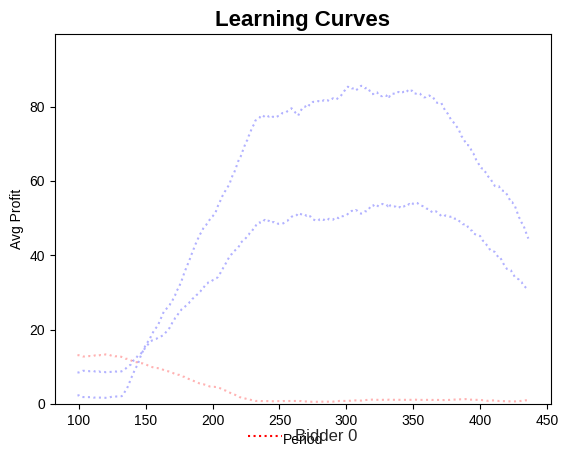

In [8]:
log.graphLearning(trackBuyersIdx = [0], trackSellersIdx = [], rolling_window=100, type = 'period')

In [ ]:
log.graphOffers(0, 100, [0], [])

In [ ]:
log.graphSales(0, 100, trackBuyersIdx=[0], trackSellersIdx=[])

In [ ]:
log.stepData.tail(20)

In [ ]:

class Log:
    def __init__(self, gameData,disclosure):
        self.gameData = gameData
        self.gameTypes, self.numBuyers, self.numSellers, self.numTokens, self.numRounds, self.numPeriods, self.numSteps, self.seed = gameData
        self.stepData = pd.DataFrame(columns=['rnd', 'period', 'step', 'bids','asks','currentBid','currentBidIdx','currentAsk',
                                             'currentAskIdx','buy','sell','price','sale', 'bprofit', 'sprofit'])
        self.roundData = pd.DataFrame(columns=['rnd', 'buyerValues', 'sellerCosts', 'demand', 'supply', 'prices', 'peq', 'qeq', 
                                              'buyerReservationPrices', 'sellerReservationPrices', 'buyerSurplus', 'sellerSurplus', 
                                              'totalSurplus', 'buyerSurplusFrac', 'sellerSurplusFrac'])
        self.disclosure = disclosure
        
    def addStep(self, stepData):
        self.stepData.loc[len(self.stepData.index)] = stepData

    def addRound(self, roundData):
        self.roundData.loc[len(self.roundData.index)] = roundData
    
    def disclose(self):
        return self.stepData[self.disclosure].iloc[-1]
        
    def getPeriod(self, rnd, period):
        return self.stepData[(self.stepData.rnd==rnd) & (self.stepData.period==period)]
        
    def getPeriodActivity(self, rnd, period):
        periodData = self.getPeriod(rnd, period)
        periodBids = list(periodData.bids)
        periodAsks = list(periodData.asks)
        periodPrices = list(periodData.price)
        periodSales = np.cumsum(np.where(periodData.price > 0,1,0))
        return np.array(periodBids), np.array(periodAsks), np.array(periodPrices), np.array(periodSales)

    def getRound(self, rnd):
        return self.roundData[(self.roundData.rnd==rnd)]

    def getRoundList(self, rnd):
        return self.getRound(rnd).values.tolist()[0][1:]


    def graphSales(self, rnd, period, trackBuyersIdx = [], trackSellersIdx = []):
        colors = customGraphSettings()
        fig, ax = graphMarket(*self.gameData, *self.getRoundList(rnd))
        periodBids, periodAsks, periodPrices, periodSales = self.getPeriodActivity(rnd,period)
        plt.plot(range(1,len(periodPrices)+1), periodPrices, color='black', linestyle='dashdot', label='Actual Prices')
        
        for j in range(self.numBuyers):
            y = [periodSales[i] for i in range(self.numSteps) if periodPrices[i] > 0]
            x = [periodBids[i][j] for i in range(self.numSteps) if periodPrices[i] > 0]
            if j in trackBuyersIdx:
                plt.plot(y, x, linestyle='dotted', color = 'red')
            else:
                plt.plot(y, x, linestyle='dotted', color = 'red', alpha = 0.2)
                
        for j in range(self.numSellers):
            y = [periodSales[i] for i in range(self.numSteps) if periodPrices[i] > 0]
            x = [periodAsks[i][j] for i in range(self.numSteps) if periodPrices[i] > 0]
            if j in trackSellersIdx:
                plt.plot(y, x, linestyle='dotted', color = 'blue')
            else:
                plt.plot(y, x, linestyle='dotted', color = 'blue', alpha = 0.2)
                
        for i in range(self.numSteps):
            if (periodPrices[i] > 0):
                ax.scatter([periodSales[i]] * len(periodBids[i]), periodBids[i], s=10, alpha=0.2, c='red')
                ax.scatter([periodSales[i]] * len(periodAsks[i]), periodAsks[i], s=10, alpha=0.2, c='blue')
                
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=5)
        ax.set_title('Dynamic Double Auction - Transactions', fontsize=16, fontweight='bold')
        plt.text(0.90, 0.10, f'Round: {rnd}', transform=plt.gca().transAxes, alpha=0.5)
        plt.text(0.90, 0.05, f'Period: {period}', transform=plt.gca().transAxes, alpha=0.5)
        plt.show()
    

    def graphOffers(self, rnd, period, trackBuyersIdx = [], trackSellersIdx = []):
        periodBids, periodAsks, periodPrices, periodSales = self.getPeriodActivity(rnd,period)
        fig, ax = plt.subplots()
        colors = customGraphSettings()
        notTrackBuyers = [i for i in range(self.numBuyers) if i not in trackBuyersIdx]
        notTrackSellers = [i for i in range(self.numBuyers) if i not in trackSellersIdx]
        ax.plot(periodBids[:,notTrackBuyers], c='red', linestyle='dotted', alpha = 0.3)
        ax.plot(periodBids[:,trackBuyersIdx], c='red', linestyle='dotted', alpha = 1.0)
        ax.scatter(range(self.numSteps), np.max(periodBids, axis = 1), c='red', label='Winning Bids', alpha = 0.5)
        ax.plot(periodAsks[:,notTrackSellers], c='blue', linestyle='dotted', alpha = 0.3)
        ax.plot(periodAsks[:,trackSellersIdx], c='blue', linestyle='dotted', alpha = 1.0)
        ax.scatter(range(self.numSteps), np.min(periodAsks, axis = 1), c='blue', label='Winning Asks', alpha = 0.5)
        #ax.plot(periodBids, c='red', linestyle='dotted', label='Bids')
        #ax.plot(periodAsks, c='blue', linestyle='dotted', label='Asks')
        ax.plot(range(self.numSteps), periodPrices, c='black', label='Prices', linestyle='dashdot')
        #ax.scatter(range(self.numSteps), periodPrices, c='black', label='Prices')
        ax.set_title('Dynamic Double Auction - Offers', fontsize=16, fontweight='bold')
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=5)
        plt.xlabel('Price')
        plt.ylabel('Time Step')
        ax.yaxis.tick_left()
        ax.xaxis.tick_bottom()
        ax.xaxis.set_label_position('bottom')
        ax.set_yticks(np.arange(0, 100, 5))
        ax.set_xticks(np.arange(0, len(periodSales), 1))
        plt.text(0.90, 0.10, f'Round: {rnd}', transform=plt.gca().transAxes, alpha=0.5)
        plt.text(0.90, 0.05, f'Period: {period}', transform=plt.gca().transAxes, alpha=0.5)
        plt.show()


    def graphLearning(self, trackBuyersIdx = [], trackSellersIdx = [], rolling_window = 1, type = 'period'):
        df = self.stepData
        fig, ax = plt.subplots()
        colors = customGraphSettings()
        for j in range(self.numBuyers):
            rolling_mean = df[df.currentBidIdx == j][[type, 'bprofit']].groupby([type]).sum().rolling(rolling_window).mean()
            if j in trackBuyersIdx:
                ax.plot(rolling_mean, color = 'red', alpha = 1.0, linestyle = 'dotted', label = f'Bidder {j}')
            else:
                ax.plot(rolling_mean, color = 'red', alpha = 0.3, linestyle = 'dotted')
                
        for j in range(self.numSellers):
            rolling_mean = df[df.currentAskIdx == j][[type, 'sprofit']].groupby([type]).sum().rolling(rolling_window).mean()
            if j in trackSellersIdx:
                ax.plot(rolling_mean, color = 'blue', alpha = 1.0, linestyle = 'dotted', label = f'Asker {j}')
            else:
                ax.plot(rolling_mean, color = 'blue', alpha = 0.3, linestyle = 'dotted')
        
        ax.set_title('Learning Curves', fontsize=16, fontweight='bold')
        plt.xlabel('Period')
        plt.ylabel('Avg Profit')
        ax.yaxis.tick_left()
        ax.xaxis.tick_bottom()
        ax.xaxis.set_label_position('bottom')
        #ax.set_yticks(np.arange(0, 100, 5))
        #ax.set_xticks(np.arange(0, 100, 20))
        #ax.text(0.80, 0.10, f'Round: {rnd}', transform=plt.gca().transAxes, alpha=0.5)
        #ax.text(0.80, 0.05, f'Period: {period}', transform=plt.gca().transAxes, alpha=0.5)
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=5)
        plt.ylim(ymin=0)
        plt.show()